In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# Declare a Base using automap_base()
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station

measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date)\
    .order_by(measurement.date.desc()).first()[0]
    

print(most_recent_date)

2017-08-23


In [10]:
# Calculate the date one year from the last date in data set.
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d').date()

year_before_most_recent = most_recent_date - timedelta(days = 365)

print(year_before_most_recent)

2016-08-23


Text(0, 0.5, 'Inches')

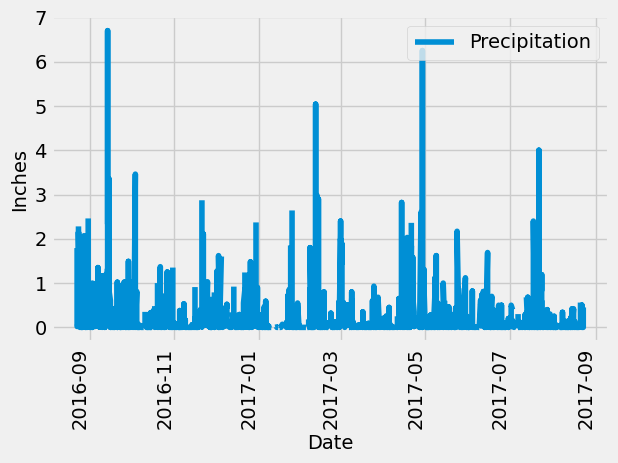

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement) \
        .with_entities(measurement.date, measurement.prcp) \
        .filter(measurement.date >= year_before_most_recent)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query.statement, query.session.bind)
df = df.rename( columns = { 'date' : 'Date', "prcp" : "Precipitation"})

# Sort the dataframe by date
df = df.sort_values(by = "Date")

# Use Pandas Plotting with Matplotlib to plot the data
df["Date"] = pd.to_datetime(df["Date"], format = '%Y-%m-%d')

df= df.set_index("Date")

ax_1 = df.plot(rot = 90)
plt.legend(loc = 'upper right')
ax_1.set_ylabel("Inches")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df["Precipitation"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(measurement).group_by(measurement.station).count()

print(f"The number of stations is {station_count}")

The number of stations is 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

query = sqlalchemy.select([measurement.station,
                            sqlalchemy.func.count(measurement.station)
                          ]) \
                        .group_by(measurement.station) \
                        .order_by(func.count(measurement.station).desc())

result = engine.execute(query).fetchall()

for station in result:
    print(station)
    


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# save the most active station and print it out

most_active_station_tup = result[0]

most_active_station = most_active_station_tup[0]
most_active_station_count = most_active_station_tup[1]

print(f"The most active station is station {most_active_station} and it has {most_active_station_count} observations.")

The most active station is station USC00519281 and it has 2772 observations.


In [16]:
# filter out null values for temperature for most active station

most_active_temps = []

query = session.query(measurement) \
        .with_entities(measurement.tobs) \
        .filter(measurement.station == most_active_station)

for record in query:
    if type(record.tobs) == float:
        most_active_temps.append(record.tobs)

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = min(most_active_temps)
highest_temp = max(most_active_temps)
mean_temp = np.mean(most_active_temps)

print(f"The lowest temperature for the most active station was {lowest_temp}")
print(f"The highest temperature for the most active station was {highest_temp}")
print(f"The average temperature for the most active station was {mean_temp}")

The lowest temperature for the most active station was 54.0
The highest temperature for the most active station was 85.0
The average temperature for the most active station was 71.66378066378067


Text(0.5, 0, 'Temperature')

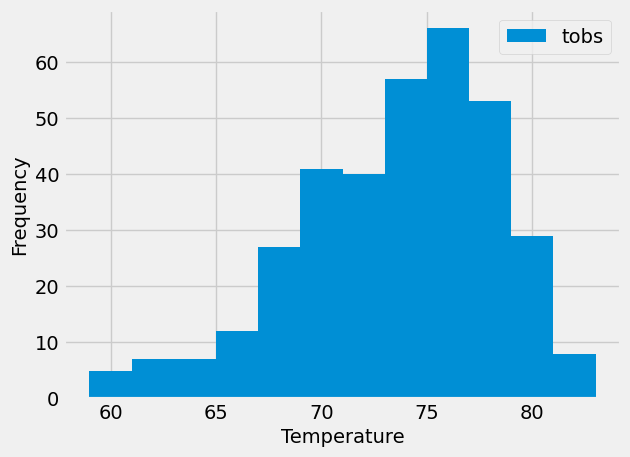

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_tobs = session.query(measurement) \
        .with_entities(measurement.tobs) \
        .filter(measurement.date >= year_before_most_recent) \
        .filter(measurement.station == most_active_station)

df_tobs = pd.read_sql(query_tobs.statement, query_tobs.session.bind)

ax = df_tobs.plot(kind = "hist", bins = 12)

ax.set_xlabel("Temperature")


# Close Session

In [19]:
# Close Session
session.close()